<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/yolov11_milling_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI를 이용한 밀링헤드 모니터링 실습**💡

*   **목적** : 머신비전을 이용하여 밀링헤드의 파손부위를 검출하는 예제

*   **알고리즘** : 객체 검출(Object Detection) 알고리즘 YOLOv11 (출처: https://docs.ultralytics.com/ko/models/yolo11/)

*   **데이터셋** : Edge milling heads Dataset (출처: https://gvis.unileon.es/datasets-emh-144/)

 *해당 데이터셋은 현재 연구목적으로 전달받은 데이터로 배포 금지 요망*


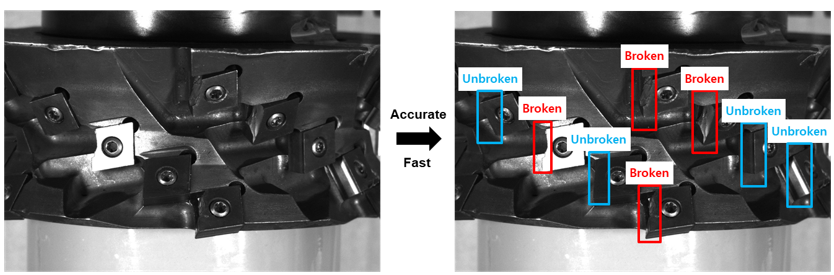



 ### **Colab 런타임 유형 변경 (CPU -> GPU)**
 * 딥러닝을 이용한 이미지 학습에는 CPU보다 GPU 연산이 속도가 빠름
 * Colab의 런타임 유형은 CPU가 기본으로 되어있어서 GPU로 변경하는 것이 좋음
 * 메뉴 > 런타임 > 런타임유형변경에서 GPU로 선택을 변경할 수 있음


 ## **1. 데이터 준비**

### **1.1. 데이터 소개**

* 6개의 밀링헤드에 대하여 각각 24장의 이미지를 촬영하여, 총 120장의 이미지를 저장하고 있음
* 가공 중 밀링헤드의 정지 시점에 약간씩 회전하면서 촬영한 정지영상을 사용하여 파손 여부를 진단함
* 하나의 밀링헤드에는 30개의 insert가 장착되어 있으며, 이 insert 중에서 사용 중에 파손된 insert를 탐지하는 것을 목표로 함
* 정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링


 ### **1.2. 데이터 라벨링**

*   이미지 학습을 위하여 데이터의 분류값을 지정하는 것을 데이터 라벨링(data labeling)이라고 하며, 이미지 데이터에 대해서도 사전에 수작업으로 이미지의 어떤 부분에 어떤 객체가 존재하는지 지정해야하며 이를 데이터 라벨링 또는 데이터 어노테이션(annotation)이라고 함
*   정상 insert는 'unbroken', 깨진 insert는 'broken'으로 라벨링
*   라벨링 완료 후, YOLO format으로 export

### **1.3. 파일 업로드**
 * 아래 코드를 실행시켜서 Google Drive에 연결을 승인하시오.

In [ ]:
# 구글 드라이브 연결하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 * **milling.zip 파일을 Google Drive의 아래 폴더에 업로드한 후, 압축을 풀고 내용을 확인하시오.**
    * 파일 링크: https://drive.google.com/drive/folders/1Z1w7oLi80NpBk-CQPzOxMyNE186BXiOE
    * 폴더 예시: /content/gdrive/My Drive/Colab Notebooks/ai/milling

In [ ]:
# 1. 파일 업로드
# Google Drive의 zip 파일 압축 풀기
%cd '/content/drive/MyDrive/Colab Notebooks/ai/milling/'
!unzip -qq milling.zip

/content/drive/MyDrive/Colab Notebooks/ai/milling
replace datasets/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace datasets/images/test/HeadTool0121.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace datasets/images/test/HeadTool0122.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **2. YOLOv11 코드 불러오기**

In [ ]:
# 관련 라이브러리 설치하기
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# 2. 모델 로드 (사전 학습된 모델)
model = YOLO("yolo11n.pt")  # 사전 학습된 YOLOv11 Nano 모델 로드

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **3. 모델 학습**

### **3.1. 학습 설정 파일(.yaml) 만들기**

In [ ]:
import os

# 3. 데이터셋 경로 설정
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/'
TRAIN_IMAGES = "images/train"
VALIDATION_IMAGES = "images/validation"
TEST_IMAGES = "images/test"

# 4. 데이터셋 명세 생성
# Ultralytics는 `data.yaml` 파일이 필요합니다.
# 데이터셋 구성 YAML 파일 생성. f는 변수를 받아와서 파일을 동적 생성하기 위한 옵션
DATA_YAML_CONTENT = f"""
# root dir
# path: /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/
path: {DATASET_PATH}

# data dir  (relative to 'path')
train: {TRAIN_IMAGES}
val: {VALIDATION_IMAGES}
test: {TEST_IMAGES}

# classes
nc: 2  # number of classes
names: ['unbroken', 'broken']  # class names
"""

# data.yaml 파일 저장
yaml_path = os.path.join(DATASET_PATH, "data.yaml")
# os.makedirs(os.path.dirname(yaml_path), exist_ok=True)  # data.yaml 저장 경로 확인 및 생성
with open(yaml_path, "w") as f:
    f.write(DATA_YAML_CONTENT)
print("data.yaml 생성 완료!")

data.yaml 생성 완료!


### **3.2. YOLO 모델의 Fine-Tuning**

In [ ]:
# 4. Fine-Tuning 설정
model.train(
    data=yaml_path,             # 데이터셋 설정 파일 경로
    epochs=100,                  # 훈련할 에포크 수
    batch=16,                   # 배치 크기
    imgsz=640,                  # 입력 이미지 크기
    workers=4,                  # 데이터 로더의 워커 수
    device=0,                   # GPU 사용 (0: 첫 번째 GPU)  <- GPU를 사용하는 경우
    # device="cpu",             # CPU 사용 설정            <- CPU를 사용하는 경우
    project="YOLOv11_FineTune", # 결과를 저장할 프로젝트 이름
    name="millinghead"          # 실험 이름
)

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=millinghead4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0335b78920>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## **4. 성능 평가**

### **4.1. Test 성능 평가**

In [ ]:
# 경로 설정
MODEL_PATH =      '/content/drive/MyDrive/Colab Notebooks/ai/milling/YOLOv11_FineTune/millinghead2/weights/best.pt'           # 프로젝트로 새롭게 생성된 예측 모형 파일
MODEL_COPY_PATH = '/content/drive/MyDrive/Colab Notebooks/ai/milling/best_100.pt'   # 복사할 모형 파일명
YAML_PATH =       '/content/drive/MyDrive/Colab Notebooks/ai/milling/data.yaml'     # 데이터셋 구성 파일 경로
TEST_IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test'  # 테스트 이미지 경로
SAVE_DIR =        '/content/drive/MyDrive/Colab Notebooks/ai/milling/test_results'  # 결과 저장 경로

# !cp {source_path} {destination_path}

import shutil
shutil.copy(MODEL_PATH, MODEL_COPY_PATH)
print(f"File copied to {MODEL_COPY_PATH}")

File copied to /content/drive/MyDrive/Colab Notebooks/ai/milling/best_100.pt


In [ ]:
# 5. Test Set 성능 평가
def evaluate_test_set(model, yaml_path):
    # 테스트 성능 평가
    results = model.val(data=yaml_path, split="test", save_json=True)

    # 디버깅: 반환된 객체 구조 확인
    # print(dir(results))  # 객체의 속성 확인
    # print(results.results_dict)  # results_dict 내용 확인
    print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
    print(f"Recall: {results.results_dict['metrics/recall(B)']:.4f}")
    print(f"mAP@50: {results.results_dict['metrics/mAP50(B)']:.4f}")
    print(f"mAP@50-95: {results.results_dict['metrics/mAP50-95(B)']:.4f}")

    # 결과 저장 디렉토리 확인
    print("\n결과가 저장된 경로:")
    print(results.save_dir)

# 6. 학습된 모델 로드 및 테스트 실행
TEST_IMAGE_PATH = os.path.join(DATASET_PATH, "images/test")
# TEST_IMAGE_PATH = DATASET_PATH + "images/test"

if os.path.exists(MODEL_PATH):
    print("\n학습된 모델 로드 중...")
    model = YOLO(MODEL_PATH)
    evaluate_test_set(model, yaml_path)
else:
    print("\n학습된 모델이 존재하지 않습니다. 학습을 완료한 후 실행하세요.")


학습된 모델 로드 중...
Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 1.5±0.5 MB/s, size: 1201.1 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/labels/test.cache... 24 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 24/24 31.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 10.6s/it 21.2s
                   all         24        206      0.849      0.792       0.86      0.554
              unbroken         24        154      0.834      0.949      0.916      0.659
                broken         21         52      0.864      0.635      0.804       0.45
Speed: 5.7ms preprocess, 17.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Saving /content/drive/MyDrive/Colab Notebooks/ai/milling/runs/detect/val3/predictions.json

In [ ]:
import os
from ultralytics import YOLO
from PIL import Image

def detect_and_save_results(model_path, yaml_path, test_images_dir, save_dir):
    """
    학습된 모델로 Test Set을 평가하고 Detection 결과를 저장하는 함수.

    Args:
        model_path (str): 학습된 YOLO 모델 경로.
        yaml_path (str): 데이터셋 구성 파일(data.yaml)의 경로.
        test_images_dir (str): 테스트 이미지가 있는 디렉토리 경로.
        save_dir (str): Detection 결과를 저장할 디렉토리 경로.
    """
    # 모델 로드
    model = YOLO(model_path)

    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)

    # Test Set의 모든 이미지 파일 탐색
    test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('jpg', 'png', 'bmp'))]

    if not test_images:
        print("테스트 이미지가 존재하지 않습니다.")
        return

    print(f"{len(test_images)}개의 테스트 이미지를 처리합니다...")

    # 각 이미지에 대해 Detection 수행 및 결과 저장
    for image_name in test_images:
        image_path = os.path.join(test_images_dir, image_name)

        # Detection 수행
        results = model(image_path, save=False)  # save=False로 설정하여 자동 저장 방지

        # 시각화된 결과 이미지 가져오기
        result_image = results[0].plot()  # 첫 번째 이미지의 결과 시각화

        # 저장 경로 설정
        output_path = os.path.join(save_dir, image_name)

        # 결과 이미지를 저장
        result_image_pil = Image.fromarray(result_image)  # numpy array -> PIL 이미지 변환
        result_image_pil.save(output_path)
        print(f"결과 저장: {output_path}")

    print("\n모든 Detection 결과가 저장되었습니다!")

# 함수 실행
detect_and_save_results(MODEL_PATH, YAML_PATH, TEST_IMAGES_DIR, SAVE_DIR)

24개의 테스트 이미지를 처리합니다...

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0144.bmp: 480x640 8 unbrokens, 1 broken, 48.4ms
Speed: 1.8ms preprocess, 48.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0144.bmp

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0129.bmp: 480x640 9 unbrokens, 1 broken, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0129.bmp

image 1/1 /content/drive/MyDrive/Colab Notebooks/ai/milling/datasets/images/test/HeadTool0133.bmp: 480x640 10 unbrokens, 2 brokens, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/HeadTool0133.bmp

image 1/1 /c

* **결과를 확인해봅니다.**

결과 저장: /content/drive/MyDrive/Colab Notebooks/ai/milling/test_results/XXX.bmp